In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import copy
import os 
import pickle
import scipy
import matplotlib
from sklearn.decomposition import PCA

import sys; sys.path.append("./scripts/")
from utils_ import load_data

from sklearn.manifold import TSNE
from sklearn.covariance import MinCovDet

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [2]:
v1_morph = pd.read_csv("./results/classification/two_features_full__res_MC_LBC_SBC_DBC_BPC_HBC_NGC_alpha_05.csv")
v1_ephys = pd.read_csv("./results/classification/ephys.csv")

del v1_morph['Unnamed: 0']
del v1_ephys['Unnamed: 0']

### get morphology classification data

In [3]:
data_morph = copy.copy(v1_morph)

s='avg_test_score'
p_morph = data_morph.pivot_table(index='group_a', columns='group_b', values=s, fill_value=0)
index_morph = p_morph.index.union(p_morph.columns).values
order_morph = ['LBC','DBC','SBC','HBC','MC','BPC','NGC']
p_morph = p_morph.reindex(index=order_morph, columns=order_morph, fill_value=0)

# include pyramidal cells even though they are not in the data
r_morph = np.zeros((p_morph.shape[0]+1, p_morph.shape[0]+1))
r = p_morph.values
r_morph[1:,1:] = r + r.T

mask_morph = np.zeros_like(r_morph, dtype=np.bool)
mask_morph[np.tril_indices_from(mask_morph)] = True
mask_morph[0,:] = True

### compute morphology embedding

In [4]:
files = ['./data/density_map_xz_full.csv', './data/morphometric_statistic_full.csv']

data = pd.read_csv(files[0], index_col='name')
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)
cells = np.array([c[:-4] for c in data.index])
y_morph = data['type'].values.astype(str)

for i, file in enumerate(files):
    data = pd.read_csv(files[i], index_col='name')
    if 'Unnamed: 0' in data.columns:
        data = data.drop('Unnamed: 0', axis=1)
    index = np.array([c[:-4] for c in data.index])
    ind = [list(index).index(c) for c in cells]
    data = data.iloc[ind,:]    
    data = data.drop('type', axis=1)
    
    morphFeatures = np.array(data.columns)#[1:]
    X = data.values.astype('float')
        
    Z = X.copy()
    if file.find('morph') > -1: 
        Z = Z[:, (morphFeatures!='min_tortuosity') & (morphFeatures!='min_path_angle')]
        
    Z = Z - Z.mean(axis=0)
    if file.find('morph') > -1:        
        Z = Z / (Z.std(axis=0))

    U,s,V = np.linalg.svd(Z, full_matrices=False)
    Z = U @ np.diag(s)
    Z = Z[:,:10]
    Z = Z / np.std(Z[:,0])
            
    if i==0:
        ZZ = Z.copy()
    else:
        ZZ = np.concatenate((ZZ,Z), axis=1)

U,s,V = np.linalg.svd(ZZ, full_matrices=False)
ZZ = U @ np.diag(s)
ZZ_morph = TSNE(perplexity=15, method='exact', random_state=42, early_exaggeration=4).fit_transform(ZZ)

### get ephys classification data

In [5]:
data_ephys = copy.copy(v1_ephys)

data_ephys.loc[data_ephys['group_a'] == 'NFC','group_a'] = 'NGC'
data_ephys.loc[data_ephys['group_b'] == 'NFC','group_b'] = 'NGC'

s='avg_test_score'
p = data_ephys.pivot_table(index='group_a', columns='group_b', values=s, fill_value=0)
index_ephys = p.index.union(p.columns).values
order_ephys = ['PYR','LBC','DBC','SBC','HBC','MC','BPC','NGC']
p = p.reindex(index=order_ephys, columns=order_ephys, fill_value=0)

r = p.values
r_ephys = r + r.T
mask_ephys = np.zeros_like(p, dtype=np.bool)
mask_ephys[np.tril_indices_from(mask_ephys)] = True

### compute ephys embedding

In [22]:
ephys = pd.read_csv('../ephys/data/patch-morph-ephys-features.csv', index_col='name sample')
y_ephys = ephys['Cell type'].values.astype(str)
cells_ephys = np.array([c for c in ephys.index])
ind = np.array(ephys.columns)[:-1]
X = ephys.iloc[:,:-1].values.astype('float')

X = X[y_ephys != 'NMC',:]
y_ephys = y_ephys[y_ephys != 'NMC']

#rename 
y_ephys[y_ephys== 'SC'] = 'SBC'
y_ephys[y_ephys == 'HEC'] = 'HBC'
y_ephys[y_ephys == 'BC'] = 'LBC'
# log transform AI
X[:,np.isin(ind, ['AI (%)'] )] = np.log(X[:,np.isin(ind, ['AI (%)'] )]/100)

# drop ADP and latency
X = X[:,~np.isin(ind, ['ADP (mV)','Latency (ms)'] )]

XX = X.copy()
XX = XX - XX.mean(axis=0)
XX = XX / XX.std(axis=0)
U,s,V = np.linalg.svd(XX, full_matrices=False)
Z = U @ np.diag(s)

ZZ_ephys = TSNE(perplexity=15, method='exact', random_state=42, early_exaggeration=4).fit_transform(Z)

## Plot figure

In [17]:
def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7
    
sns_styleset()

In [18]:
def coverageEllipse(data, coverage=.8, edgecolor=None, facecolor='none', linewidth=1, 
                    zorder=None, robust=False, label=None, fontsize=8, bbox=None, 
                    textcolor='w', labeloffset=(0,0)):
    multiplier = scipy.stats.chi2.ppf(coverage, 2)

    if robust:
        from sklearn.covariance import MinCovDet
        mcd = MinCovDet(random_state=42).fit(data)
        mu = mcd.location_
        Sigma = mcd.covariance_
    else:
        mu = data.mean(axis=0)
        Sigma = np.cov(data, rowvar=False)

    val, vec = np.linalg.eigh(Sigma)
    width, height = 2 * np.sqrt(val[:, None] * multiplier)
    theta = np.degrees(np.arctan2(*vec[::-1, 0]))
    ellip = matplotlib.patches.Ellipse(xy=mu, width=width, height=height, angle=theta, 
        edgecolor=edgecolor, linewidth=linewidth, facecolor=facecolor, zorder=zorder)
    plt.gca().add_artist(ellip)
    
    if label:
        plt.text(mu[0]+labeloffset[0], mu[1]+labeloffset[1], label, 
                 color=textcolor, fontsize=fontsize, ha='center', va='center', bbox=bbox)

<IPython.core.display.Javascript object>


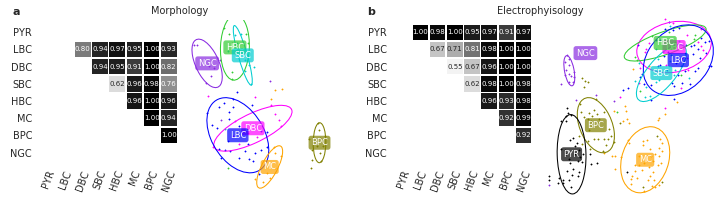

In [25]:
plt.figure(figsize=(7.2, 2))

colors = {'BPC':'#808000', 'MC':'#fea400', 'DBC':'#fe00fe', 'HBC':'#32cc32',
          'SBC':'#00cdd0', 'PYR':'#000000', 'LBC':'#0000fe', 'NGC':'#892be1'}

# rename
order_ephys = ['PYR', 'LBC', 'DBC', 'SBC', 'HBC', 'MC', 'BPC', 'NGC']

################################
# plot morphology classification
plt.subplot(1,4,1)
sns.heatmap(r_morph, mask=mask_morph, cmap='Greys', vmin=.5, vmax=1, center=.75, square=True, linewidths=.5,
                   cbar=False, annot=True,fmt='.2f', annot_kws={"size": 5})
plt.gca().set_xticklabels(order_ephys, rotation=70)
plt.xlabel('')
plt.gca().set_yticklabels(order_ephys, rotation=0)
plt.ylabel('')
plt.gca().tick_params(axis='both', which='both', length=0)
plt.text(-.2, 1.06,  'a', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')


################################
# plot ephys classification
plt.subplot(1,4,3)
sns.heatmap(r_ephys, mask=mask_ephys, cmap='Greys', vmin=.5, vmax=1, center=.75, square=True, linewidths=.5,
                   cbar=False, annot=True,fmt='.2f', annot_kws={"size": 5})
plt.gca().set_xticklabels(order_ephys, rotation=70)
plt.xlabel('')
plt.gca().set_yticklabels(order_ephys, rotation=0)
plt.ylabel('')
plt.gca().tick_params(axis='both', which='both', length=0)
plt.text(-.2, 1.06,  'b', transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

plt.tight_layout()


################################
# plot morphology embedding
plt.axes([.26, 0.05, .2, .85])

labels, yy = np.unique(y_morph, return_inverse=True)

for cl in range(labels.size):
    plt.scatter(ZZ_morph[yy==cl,0], ZZ_morph[yy==cl,1], color=colors[labels[cl]], s=1)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])


for cl,l in enumerate(labels):
    props = dict(boxstyle='round', facecolor=colors[l], edgecolor='none', alpha=0.7)
    coverageEllipse(ZZ_morph[yy==cl,:], edgecolor=colors[l], robust=True, 
                    label=labels[cl], bbox=props, fontsize=6, linewidth=0.75)


################################
# plot ephys embedding
plt.axes([.75, 0, .25, .95])

labels, yy = np.unique(y_ephys, return_inverse=True)


for cl in range(labels.size):
    plt.scatter(ZZ_ephys[yy==cl,0], ZZ_ephys[yy==cl,1], color=colors[labels[cl]], s=1)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])


offsets = {'NGC': (8,6)}
for cl,l in enumerate(labels):
    props = dict(boxstyle='round', facecolor=colors[l], edgecolor='none', alpha=0.7)
    coverageEllipse(ZZ_ephys[yy==cl,:], edgecolor=colors[l], robust=True,
                    label=labels[cl], bbox=props, fontsize=6, linewidth=0.75,
                    labeloffset=(0,0) if l not in offsets else offsets[l])

sns.despine(left=True, bottom=True)
    
plt.gcf().text(.25,.93, 'Morphology', ha='center')
plt.gcf().text(.75,.93, 'Electrophyisology', ha='center')

plt.savefig('../figures/classification-and-tsne.pdf')
plt.savefig('../figures/classification-and-tsne.png', dpi=200)